# [Molecular Docking integrated in Jupyter Notebooks](https://github.com/AngelRuizMoreno/Jupyter_Dock)

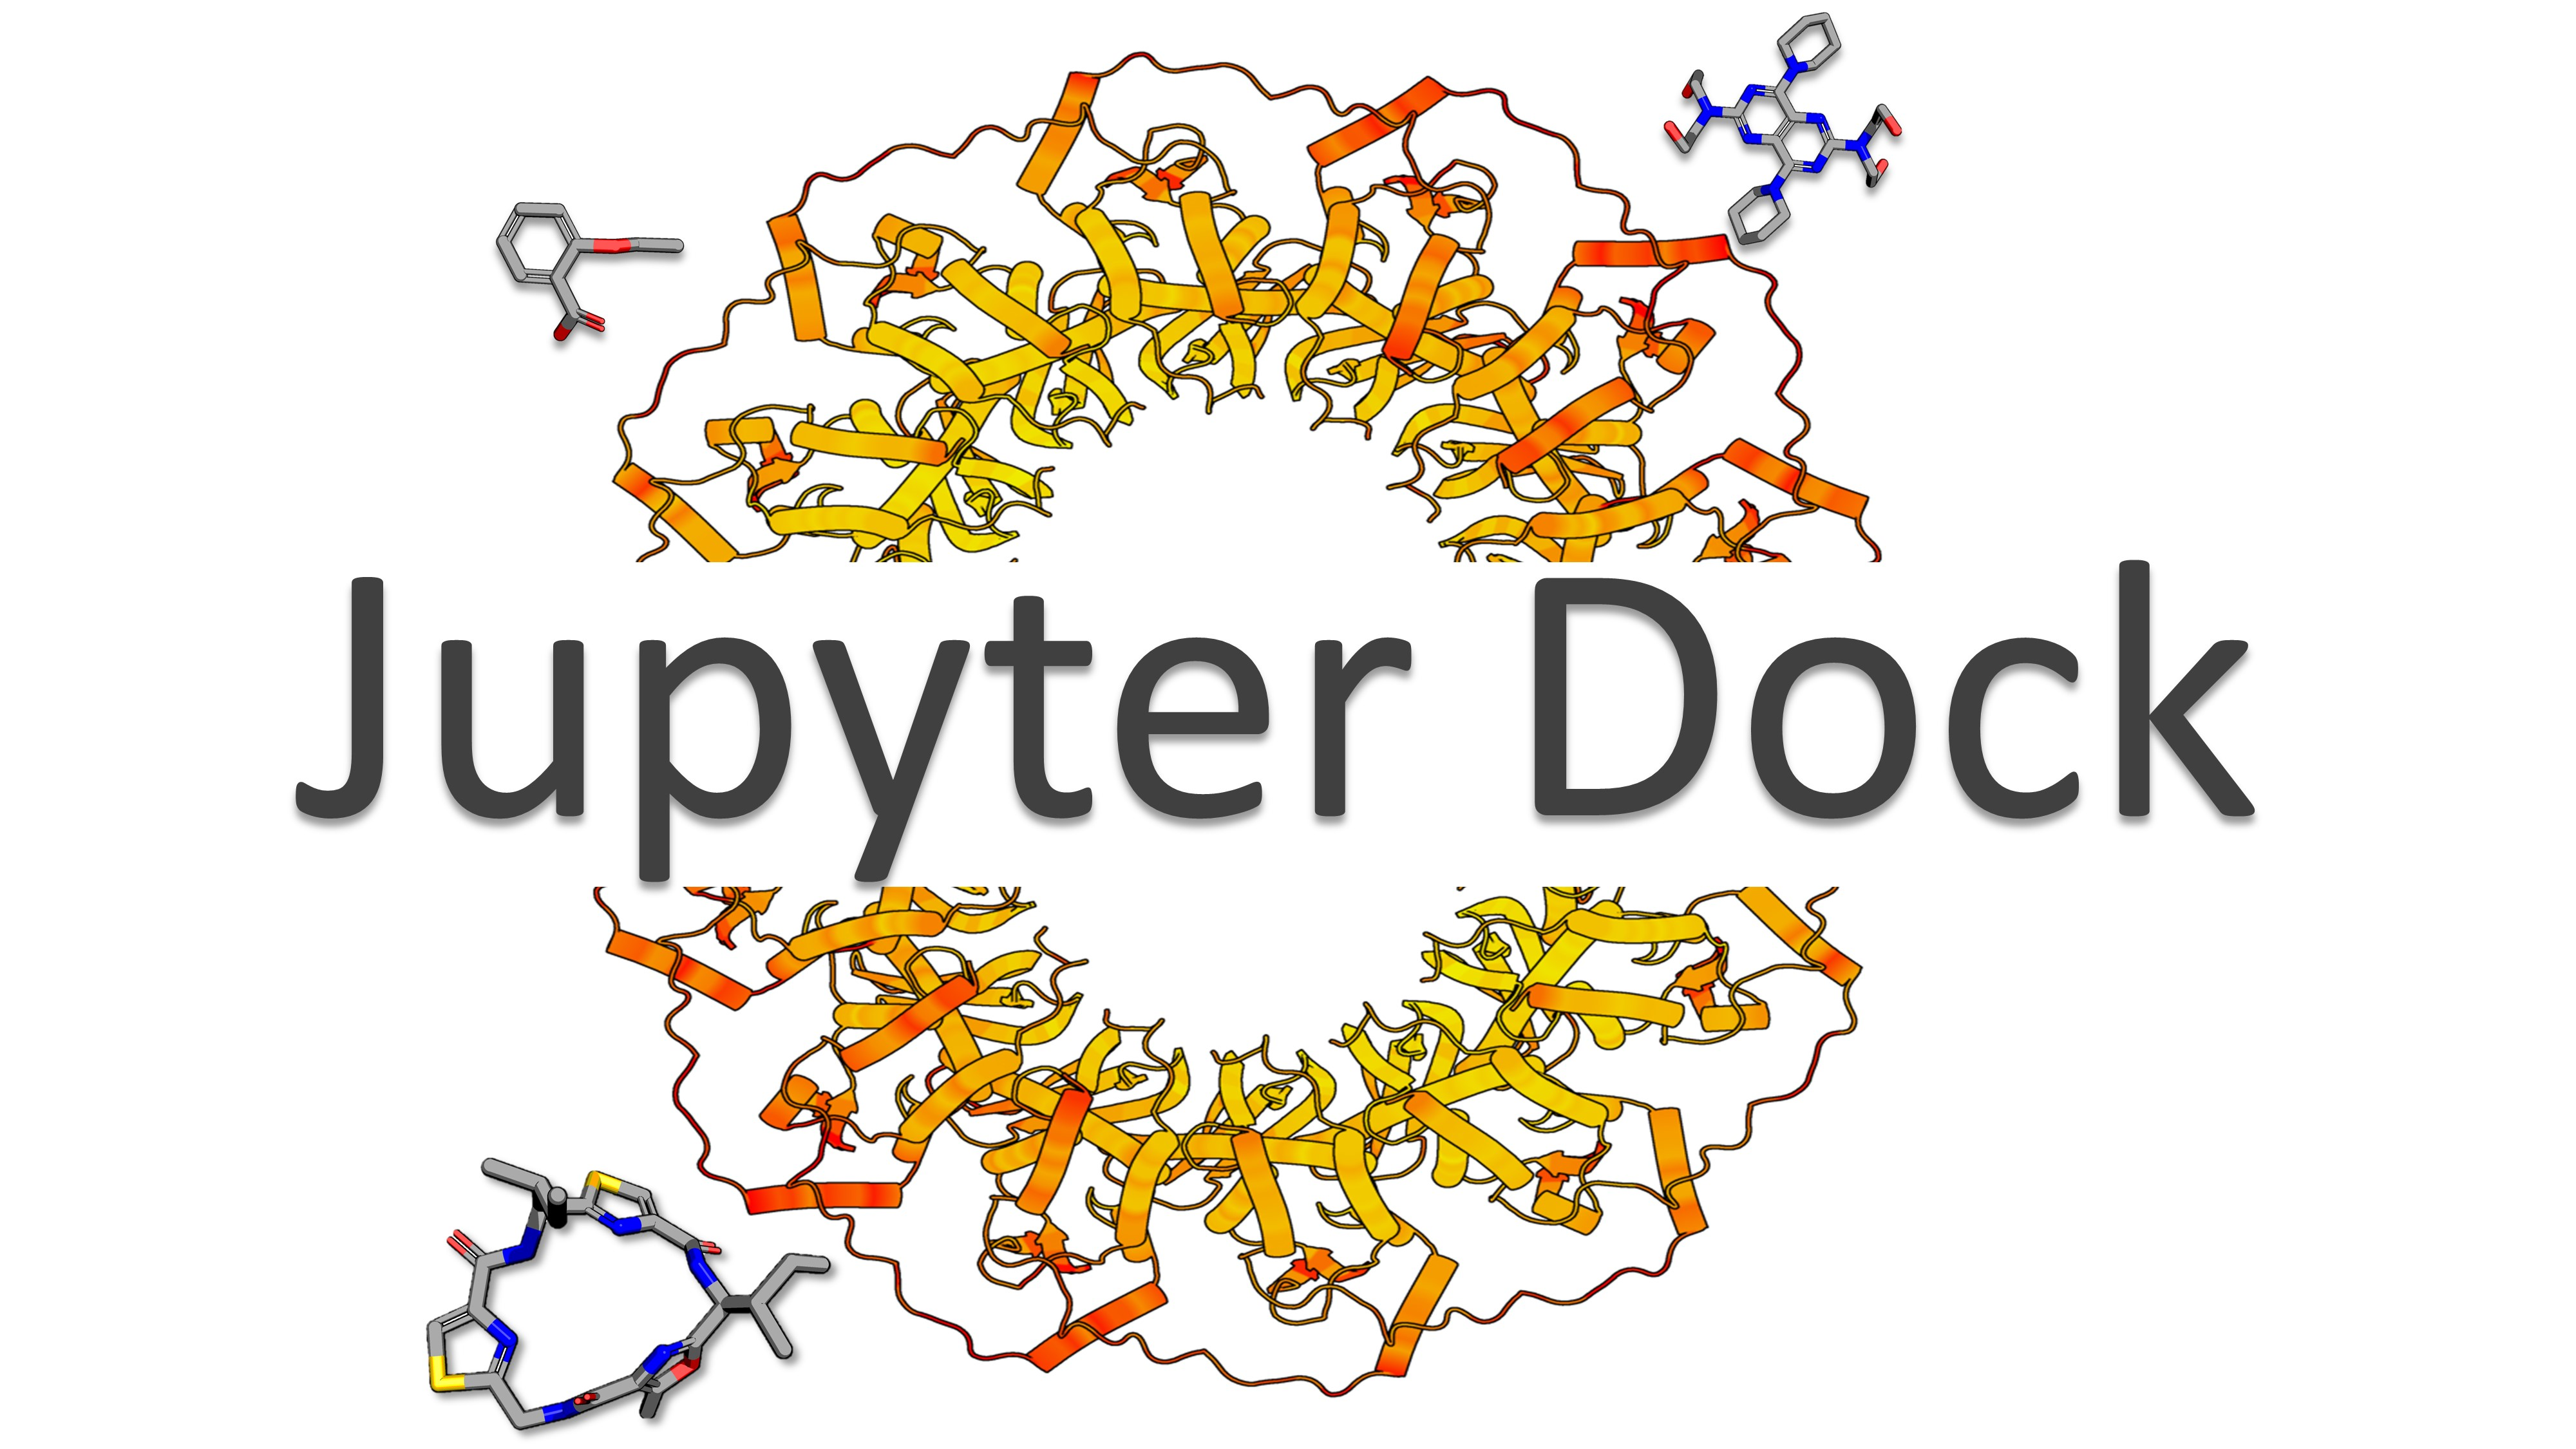

# Molecular docking

This is the main protocol of Jupyter Dock.

## Content of this notebook

1. Feching system and cleanup
2. Protein and ligand sanitization
3. System Visualization 
4. Docking with AutoDock Vina
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - PDBQT results file conversion to SDF
    - 3D visualization of docking results
    - 2D interaction table and map
5. Docking with LeDock
    - Receptor preparation
    - Ligand preparation
    - Docking box definition
    - Docking
    - DOK results file conversion to SDF
    - 3D visualization of docking results
    - 2D interaction table and map
    
# Protocols for Virtual Screening, Blind Docking, Reverse Docking, and Docking analysis in my GitHub Repo:
# https://github.com/AngelRuizMoreno/Jupyter_Dock

In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os
sys.path.insert(1, 'utilities/')
from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

It's a good idea to run the test protocols before attempting custom projects. Later, the user can specify the location of his/her project and save all of the files separately.

In [2]:
os.chdir('test/Molecular_Docking/')

## 1. Feching system and cleanup

Implementing Pymol is a simple way to download PDB structures. The user can launch this or any other Jupyter Dock's protocol by providing his or her own files.

In [3]:
cmd.fetch(code='1AZ8',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1AZ8_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1AZ8_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


## 2. Protein and ligand sanitization

### 2.1. Protein Sanitization

#### Method 1: LePro

The Lephar molecular docking suite includes a very powerful tool for automatically preparing proteins for molecular docking. As a result, for these protocols, it will be the preferred tool for protein preparation. The protein prepared by LePro can be used in AutoDock VIna and LeDock.

In [4]:
!../../bin/lepro_linux_x86 # Launch this cell to see parameters

************************************************************
*      LePro                                               *
*            Add hydrogen atoms to a protein &             *
*            write the input file for LeDock               *
*      Copyright (C) 2013-14 Hongtao Zhao, PhD             *
*      Email: htzhaovv@gmail.com                           *
************************************************************
----------Usage:                                                                       
          lepro [PDB file] [-rot || -metal || -p]                                        
          -rot  [[chain] resid] align principal axes of the binding site with Cartesian
          -metal keep ZN/MN/CA/MG                                                      
          -metal -p redistribute metal charge to protein                               



In [5]:
!../../bin/lepro_linux_x86 {'1AZ8_clean.pdb'}

os.rename('pro.pdb','1AZ8_clean_H.pdb') # Output from lepro is pro.pdb, this line will change the name to '1AZ8_clean_H.pdb'

#### Method 2: fix_protein (PDBFixer)

For proteins with missing amino acids or residues, or to ensure a more thorough sanitization of protein Jupyter Dock includes the _fix_protein()_ function, which employs PDBFixer to correct a wide range of common errors in protein pdb files. Furthermore, PDBFixer enables the assignment of pH-dependent protonation states to proteins.


>**Warning 1:**  It is possible to encounter problems with protein fixing when using **_fix_protein()_** and AutoDock Tools' **_prepare_receptor_** or when running LeDock. To resolve the issue, it is best to set the parameter _-A hydrogens_ in _prepare receptor_.


>**Hint:** PDBFixer is a great solution for many systems because it can solve serious problems in PDB files. As a result, PDBFixer renumbers the residues beginning with 1 regardless of the numbering on the original PDB file. To address this issue, the **_fix_protein()_** function includes a protocol for atomically renumbering the residues in accordance with the original PDB file.


**_fix_protein ( params )_**

Params:
      
  - **filename**: _str or path-like_ ; input file containing protein struture to be modified, file extrension must be pdb

  - **addHs_pH**: _float_ ; Add hydrogens at user defined pH

  - **try_renumberResidues**: _bool_ ; By default PDBFixer renumarets residues starting in 1, this option tries to recover originar residues numbering
    
  - **output**: _str or path-like_ ; output filename, extension must be pdb

```
fix_protein(filename='1AZ8_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1AZ8_clean_H.pdb')
```

### 2.2. Ligand sanitization

Due to the variability of ligands and formats, ligand sanitization and preparation can be one of the most difficult tasks to complete. Setting protonation states for a ligand, for example, can be difficult. It is highly recommended that the user knows and understands the proper states for his/her ligand(s) when using Jupyter Dock or any other molecular docking approach.

In this example, after splitting the ligand and protein after fetching with pymol, the ligand has sanitization problems **(sanitize=False in Chem.MolFromMol2File)**

RDKit WARNING: [20:18:05] 1AZ8: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


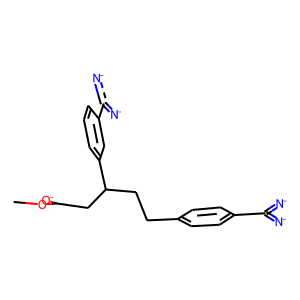

In [6]:
m=Chem.MolFromMol2File('1AZ8_lig.mol2',sanitize=False)
Draw.MolToImage(m)

>**Hint:** One solution for simple sanitization problems is to use OpenBAbel to convert the molecule and add the necessary hydrogens for molecular docking (Pybel). The definitions for carrying out molecules in OpenBabel differ from those in RDKIt. As a result, OpenBabel is capable of handling the conversion.

In [7]:
mol= [m for m in pybel.readfile(filename='1AZ8_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1AZ8_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

The end result of ligand sanitization is a new molecule that RDKit can display without having to use the sanitization parameter. Furthermore, the output structure for this example corresponds exactly to the one reported in the PDB database (PDB 1AZ8)

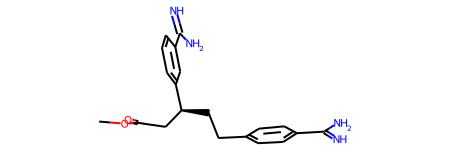

In [8]:
m=Chem.MolFromMol2File('1AZ8_lig_H.mol2')
m

## 3. System Visualization

A cool feature of Jupyter Dock is the posibility of visualize ligand-protein complexes and docking results into the notebbok. All this thanks to the powerful py3Dmol. 

Now the protein and ligand have been sanitized it would be recomended to vissualize the ligand-protein reference system.

In [9]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 4. Docking with AutoDock Vina

AutoDock Vina (Vina) is one of the docking engines in the AutoDock Suite, together with AutoDock4 (AD4), AutoDockGPU, AutoDockFR, and AutoDock-CrankPep, and arguably among the most widely used and successful docking engines. The reasons for this success are mostly due to its ease of use and its speed (up to 100x faster than AD4), when compared to the other docking engines in the suite and elsewhere, as well as being open source.

### 4.1. Protein preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand. 

>**Hint:** Despite the fact that the PDBQT format includes changes (Q) and atom types (T) for molecular docking. The charges are not required for Autodock Vina, which computes electrostatic interactions using its own force field. Although, when using AutoDock instead of AutoDock Vina, the Q term is required. More information can be found here:https://autodock-vina.readthedocs.io/en/latest/introduction.html

#### Method 1: AutoDock Tools prepare_receptor

The AutoDock Tools are the best way to prepare the receptor for AutoDock Vina. Nonetheless, AutoDock Tools is a comprehensive suite of programs and scripts that are difficult to manage. Jupyter Dock execute the **_prepare receptor_** and **_prepare_ligand_** functions on their own. As a result, obtaining proper PDBQT files for AutoDock Vina has never been easier.

>**Warning:** There is currently only one method for preparing a PDBQT file for a receptor. It is expected that new methods apart from AutoDock Tools executables will be included in the near future into Jupyter Dock.

In [10]:
!../../bin/prepare_receptor #Lauch this cell to see parameters

prepare_receptor4: receptor filename must be specified.
Usage: prepare_receptor4.py -r filename

    Description of command...
         -r   receptor_filename 
        supported file types include pdb,mol2,pdbq,pdbqs,pdbqt, possibly pqr,cif
    Optional parameters:
        [-v]  verbose output (default is minimal output)
        [-o pdbqt_filename]  (default is 'molecule_name.pdbqt')
        [-A]  type(s) of repairs to make: 
             'bonds_hydrogens': build bonds and add hydrogens 
             'bonds': build a single bond from each atom with no bonds to its closest neighbor
             'hydrogens': add hydrogens
             'checkhydrogens': add hydrogens only if there are none already
             'None': do not make any repairs 
             (default is 'None')
        [-C]  preserve all input charges ie do not add new charges 
             (default is addition of gasteiger charges)
        [-p]  preserve input charges on specific atom types, eg -p Zn -p Fe
        [-U]  cle

In [11]:
!../../bin/prepare_receptor -v -r 1AZ8_clean_H.pdb -o 1AZ8_clean_H.pdbqt

set verbose to  True
set receptor_filename to  1AZ8_clean_H.pdb
set outputfilename to  1AZ8_clean_H.pdbqt
read  1AZ8_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  1AZ8_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide


### 4.2. Ligand preparation

As previously discussed, one of the major challenges for proper docking experimentation is ligand preparation.

>**Hint:** The hydroges in this example were set during the ligand sanitization step (section 2.2). As a result, the ligand will be prepared as is. Furthermore, before running the docking, it is highly recommended to inspect the ligand(s) after preparation to ensure proper structure and molecule features.

#### Method 1: AutoDock Tools prepare_ligand

In [12]:
!../../bin/prepare_ligand #Launch this cell to see parameters

prepare_ligand4: ligand filename must be specified.
Usage: prepare_ligand4.py -l filename

    Description of command...
         -l     ligand_filename (.pdb or .mol2 or .pdbq format)
    Optional parameters:
        [-v]    verbose output
        [-o pdbqt_filename] (default output filename is ligand_filename_stem + .pdbqt)
        [-d]    dictionary to write types list and number of active torsions 
        [-A]    type(s) of repairs to make:
		 bonds_hydrogens, bonds, hydrogens (default is to do no repairs)
        [-C]    do not add charges (default is to add gasteiger charges)
        [-p]    preserve input charges on an atom type, eg -p Zn
               (default is not to preserve charges on any specific atom type)
        [-U]    cleanup type:
		 nphs_lps, nphs, lps, '' (default is 'nphs_lps') 
        [-B]    type(s) of bonds to allow to rotate 
               (default sets 'backbone' rotatable and 'amide' + 'guanidinium' non-rotatable)
        [-R]    index for root
        

In [13]:
!../../bin/prepare_ligand -v -l 1AZ8_lig_H.mol2 -o 1AZ8_lig_H.pdbqt

set verbose to  True
set ligand_filename to  1AZ8_lig_H.mol2
set outputfilename to  1AZ8_lig_H.pdbqt
read  1AZ8_lig_H.mol2
setting up LPO with mode= automatic and outputfilename=  1AZ8_lig_H.pdbqt
and check_for_fragments= False
and bonds_to_inactivate= 
returning  0
No change in atomic coordinates


#### Method 2: Meeko

This is the preferred method out of AutoDock Tools. Apart from ligand preparation, Meeko provides tools for other docking aspects that the AutoDock Tools software suite does not cover. Hydrated docking and macrocycles are two examples. More about Meeko https://pypi.org/project/meeko/

>**Info**  To run Meeko change the next cell type from "Markdown" to "Code".

```
mol = obutils.load_molecule_from_file('1AZ8_lig_H.mol2')

preparator = MoleculePreparation(merge_hydrogens=True,hydrate=False)
preparator.prepare(mol)

preparator.write_pdbqt_file('1AZ8_lig_H.pdbqt')
```

#### Method 3: Pybel

OpenBabel (pybel) can handle a variety of file formats and conversions between them. As a result, any chemical format file can be converted directly to PDBQT. Nonetheless, pybel may encounter issues if the source file format contains errors. 

>**Info**  To run Pybel change the next cell type from "Markdown" to "Code".

```
ligand = [m for m in pybel.readfile(filename='1AZ8_lig_H.mol2',format='mol2')][0]
out=pybel.Outputfile(filename='1AZ8_lig_H.pdbqt',format='pdbqt',overwrite=True)
out.write(ligand)
out.close()
```

### 4.3. Box definition

This is possibly the most important feature of Jupyter Dock. Making a docking box without the use of a visualizer or any other additional tools. As a result, AutoDock Vina (and LeDock) can now be run entirely in a Jupyter notebook.

Mengwu Xiao and his clever Pymol plug-in ["GetBox"](https://github.com/MengwuXiao/GetBox-PyMOL-Plugin) inspired the box definition in Jupyter Dock. 

Jupyter Dock makes use of Mengwu Xiao Pymol implementation, but this time through the Pymol API.

>**Warning:** The function **_get_box()_** is built into the Pymol API. As a result, in order to compute the docking box, the docking system files must be initialized using Pymol.

>**Hint:** The integration of **_get_box()_** as Pymol integration allows the definition of amazing boxes based on Pymol's powerful selection tools. A ligand, a residue, a set of residues, atom(s), pseudoatom(s), and any custom selection valid within the [Pymol selection algebra](https://pymolwiki.org/index.php/Selection_Algebra) can be used to set the box.  

**_get_box( params )_**

params:

   - **selection**: _str , pymol_selection_; The selection for docking box, can be atom, resn, resid, or any other pymol selection
   
   - **extending**: _float_; value to extend the boundaries of the selection
   
   - **software**: _str , 'vina','ledock', 'both'_ ; Depending on selected software the funtion will provide the box coordinates in vina, ledock, or both formats

In [14]:
cmd.load(filename='1AZ8_clean_H.pdb',format='pdb',object='prot')
cmd.load(filename='1AZ8_lig_H.mol2',format='mol2',object='lig')

center, size= getbox(selection='lig',extending=5.0,software='vina')

cmd.delete('all')

print(center,'\n',size)

{'center_x': 31.859049797058105, 'center_y': 13.347449779510498, 'center_z': 17.06589984893799} 
 {'size_x': 24.56949806213379, 'size_y': 18.123299598693848, 'size_z': 17.374399185180664}


### 4.4. Docking

#### Method 1: vina

AutoDock Vina 1.2.0, which was recently released, now allows AutoDock Vina to be executed using Python Bindings. Jupyter Dock takes advantage of this feature to make the docking protocol run entirely within a Jupyter notebook.

In [15]:
v = Vina(sf_name='vina')

v.set_receptor('1AZ8_clean_H.pdbqt')

v.set_ligand_from_file('1AZ8_lig_H.pdbqt')

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('1AZ8_lig_vina_out.pdbqt', n_poses=10, overwrite=True)

#### Metod 2: Smina

Despite the presence of Python bindings in AutoDock Vina 1.2.0, other tools that incorporate AutoDock Vina allow for cool features such as custom score functions (smina), fast execution (qvina), and the use of wider boxes (qvina-w). Jupyter Dock can run such binaries in a notebook, giving users more options.

>**Info:** The following cell contains an example of using smina to run the current docking example. However, the executable files for qvina and qvina-w are available in the Jupyter Dock repo's bin directory. As a result, the user can use such a tool by adding the necessary cells or replacing the current docking engine.

>**Info** To run smina change the cell type from "Markdown" to "Code".

In [16]:
!../../bin/smina #Lauch this cell to see parameters

Missing receptor.

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimen

##### Example 
```
!../../bin/smina -r 1AZ8_clean_H.pdbqt -l 1AZ8_lig_H.pdbqt --center_x 31.859 --center_y 13.34 --center_z 17.065 --size_x 24.569 --size_y 18.12 --size_z 17.37 --exhaustiveness 8 --num_modes 5
```

### 4.5. PDBQT results file conversion to SDF

Because of the unique characteristics of the PDBQT format, it may be difficult to visualize the results or perform other analyses after docking. As a result, Jupyter Dock automatically converts the PDFBQT format to the more common SDF format. The file conversion preserves the chemical properties of the compounds after they have been sanitized and prepared. Furthermore, the "Pose" and "Score" information is saved as a molecule attribute. Such data can be accessed directly in the file or via Pybel or RDKit.

**_pdbqt_to_sdf ( params )_**

params:

- **pdbqt_file**: _str or path-like string_ ; pdbqt file to be converted, extension must be pdbqt
- **output**: _str or path-like string_  ; output sdf file, extension must be sdf

In [17]:
pdbqt_to_sdf(pdbqt_file='1AZ8_lig_vina_out.pdbqt',output='1AZ8_lig_vina_out.sdf')

### 4.6. 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

In [18]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})


results=Chem.SDMolSupplier('1AZ8_lig_vina_out.sdf')

p=Chem.MolToMolBlock(results[0],False)

print('Reference: Magenta | Vina Pose: Cyan')
print ('Pose: {} | Score: {}'.format(results[0].GetProp('Pose'),results[0].GetProp('Score')))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan
Pose: 1 | Score: -7.669


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 4.7. 2D interaction table and map

Inspecting the molecular interactions is one of the most common analyses performed by a computational scientist following a docking experiment. As a result, Jupyter Dock uses ProLif to create a table of ligand-protein molecular interactions as well as the corresponding 2D map.

>**Info:** ProLif uses RDKit and MDAnalysis to map the molecular interaction between a ligand and a protein. As a result, some protein preparations, including the use of LePro, can result in errors that impede analysis. Jupyter Dock's _**fix protein()_** function can be used to avoid such errors and provide a suitable protein structure for the analysis.

In [19]:
fix_protein(filename='1AZ8_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1AZ8_clean_H_fix.pdb')

In [20]:
# load protein
prot = mda.Universe("1AZ8_clean_H_fix.pdb")
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
lig_suppl = list(plf.sdf_supplier('1AZ8_lig_vina_out.sdf'))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]

ligand               UNL1                                            \
protein          ASP189.A      CYS191.A      GLY216.A      GLY219.A   
interaction       HBDonor   Hydrophobic       HBDonor       HBDonor   
0                 (12, 0)       (19, 0)  (None, None)  (None, None)   
1            (None, None)       (16, 0)  (None, None)  (None, None)   
2            (None, None)       (31, 0)  (None, None)        (9, 0)   
3            (None, None)       (31, 0)  (None, None)        (9, 0)   
4            (None, None)  (None, None)  (None, None)       (25, 0)   
5            (None, None)  (None, None)       (23, 0)  (None, None)   
6            (None, None)  (None, None)  (None, None)  (None, None)   
7                 (11, 0)       (31, 0)  (None, None)       (12, 0)   
8            (None, None)       (15, 0)  (None, None)  (None, None)   
9            (None, None)  (None, None)  (None, None)  (None, None)   

ligand                     
protein           HIS57.A  
interaction       HBDonor  
0            (None, None)  
1            (None, None)  
2            (None, None)  
3            (None, None)  
4            (None, None)  
5            (None, None)  
6            (None, None)  
7            (None, None)  
8                 (11, 0)  
9            (None, None)

In [21]:
net = LigNetwork.from_ifp(results_df,lig_suppl[0],kind="frame", frame=0,rotation=270)
net.display()

## 5. Docking with LeDock

LeDock is designed for fast and accurate flexible docking of small molecules into a protein. It achieves a pose-prediction accuracy of greater than 90% on the Astex diversity set and takes about 3 seconds per run for a drug-like molecule. It has led to the discovery of novel kinase inhibitors and bromodomain antagonists from high-throughput virtual screening campaigns. It directly uses SYBYL Mol2 format as input for small molecules.

### 5.1 Receptor preparation

In LeDock, the input file for a receptor is a PDB file with explicit hydrogens in all residues. LePro was created as a tool for preparing protein structures for docking with LeDock. Thus, at this stage, we can use the file ater sanitization steps as well as a protein structure from Jupyter Dock's _**fix_protein()**_ function.

### 5.2. Ligand preparation

As previously stated, the input format for ligand in LeDock is MOL2. Similarly to the receptor preparation, we can use the ligand directly after sanitization. 

### 5.3. Docking box definition

This step can be completed in the same manner as the AutoDock Vina box definition. To obtain the identical box from AutoDock Vina docking but in LeDock format, the user only needs to change the parameter "software" from "vina" to "ledock." 

>**Info:** The implementation of the _**get_box()**_ function allows for the easy replication of binding sites between AutoDock Vina and LeDock, with the goal of replicating and comparing results between both programs.

In [22]:
cmd.load(filename='1AZ8_clean_H.pdb',format='pdb',object='prot')
cmd.load(filename='1AZ8_lig_H.mol2',format='mol2',object='lig')

X,Y,Z= getbox(selection='lig',extending=5.0,software='ledock')
cmd.delete('all')

print(X,'\n',Y,'\n',Z)

{'minX': 19.57430076599121, 'maxX': 44.143798828125} 
 {'minY': 4.285799980163574, 'maxY': 22.409099578857422} 
 {'minZ': 8.378700256347656, 'maxZ': 25.75309944152832}


### 5.4. Docking

To run LeDock, a configuration (commonly known as dock.in) file containing all docking parameters as well as information about the receptor and ligand(s) to dock is required. Jupyter Dock uses the function _**generate ledock file()**_ to generate the configuration file automatically. After configuring the parameters, the user will receive a configuration file as well as a file containing a list of ligand(s) to dock (commonly named ligand.list). After this, docking would be as simple as launching the LeDock executable and the configuration file as parameter.

**_generate_ledock_file( params )_**

params:

- **receptor**: _str or path-like string_ ; protein file for docking including hydrogens, format must be pdb 
- **x**: _2 element list of floats [ float , float ]_; Xmin and Xmax coordinates of docking box
- **y**:  _2 element list of floats [ float , float ]_; Ymin and Ymax coordinates of docking box
- **z**:  _2 element list of floats [ float , float ]_; Zmin and Zmax coordinates of docking box
- **n_poses**: _float_ ; n_of poses to retrieve from docking 
- **rmsd**: _float_ ; minimum RMSD diference between docking poses 
- **l_list**: _list of n strings or path-like strings [ lig1, lig2, lig3 ... ] ; list of ligands or ligands paths to dock 
- **l_list_outfile**: _str or path-like string_ ; filename to save the ligand list, needed for ledock to locate ligands
- **out**: _str or path-like string_ ; outfile to save docking paramemeters, needed to launch the docking

In [23]:
generate_ledock_file(receptor='1AZ8_clean_H.pdb',x=[X['minX'],X['maxX']],
                     y=[Y['minY'],Y['maxY']],
                     z=[Z['minZ'],Z['maxZ']],
                     n_poses=10,
                     rmsd=1.0,
                     l_list='1AZ8_lig_H.mol2', 
                     l_list_outfile='ledock_ligand.list1',
                     out='dock.in')

In [24]:
!../../bin/ledock_linux_x86 #Launch this cell to see parameters

************************************************************
*       LeDock v1.0                                        *
*       Molecular Docking Software                         *
*       Copyright 2013-14 (C) H. Zhao PhD                  *
*       For academic use only                              *
*       www.lephar.com                                     *
************************************************************
--------Usage:
--------ledock config.file    !docking
--------ledock -spli dok.file !split into separate coordinates



In [25]:
!../../bin/ledock_linux_x86 dock.in

### 5.5. DOK results file conversion to SDF

The end result of LeDock is a file with the dok extension that contains the docking properties in the same way that a pdb file does. Nonetheless, the dok file is not a widely used format for representing chemical structures. As a result, Jupyter Dock can convert dok files to the widely used sdf format. Jupyter Dock, like in the pdbqt to sdf conversion, will preserve the chemical features and save the "Pose" and "Score" results as molecule attributes.

**_dok_to_sdf ( params )_**

params:

   - **dok_file**: _str or path-like_ ; dok file from ledock docking

   - **output**: _str or path-like_ ; out file from ledock docking, extension must be sdf

In [26]:
dok_to_sdf(dok_file='1AZ8_lig_H.dok',output='1AZ8_lig_ledock_out.sdf')

### 5.6. 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

In [27]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1AZ8_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

results=Chem.SDMolSupplier('1AZ8_lig_ledock_out.sdf')


p=Chem.MolToMolBlock(results[0])

print('Reference: Magenta | LeDock Pose: Cyan')
print ('Pose: {} | Score: {}'.format(results[0].GetProp('Pose'),results[0].GetProp('Score')))

view.addModel(p,'mol')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

Reference: Magenta | LeDock Pose: Cyan
Pose: 1 | Score: -8.82


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### 5.7. 2D interaction table and map

Inspecting the molecular interactions is one of the most common analyses performed by a computational scientist following a docking experiment. As a result, Jupyter Dock uses ProLif to create a table of ligand-protein molecular interactions as well as the corresponding 2D map.

> **Info:** ProLif uses RDKit and MDAnalysis to map the molecular interaction between a ligand and a protein. As a result, some protein preparations, including the use of LePro, can result in errors that impede analysis. Jupyter Dock's _fix protein()_ function can be used to avoid such errors and provide a suitable protein structure for the analysis.

In [28]:
# load protein
prot = mda.Universe("1AZ8_clean_H_fix.pdb",guess_bonds=True)
prot = plf.Molecule.from_mda(prot)
prot.n_residues

# load ligands
path = str('1AZ8_lig_ledock_out.sdf')
lig_suppl = list(plf.sdf_supplier(path))
# generate fingerprint
fp = plf.Fingerprint()
fp.run_from_iterable(lig_suppl, prot)
results_df = fp.to_dataframe(return_atoms=True)
results_df

  0%|          | 0/10 [00:00<?, ?it/s]

ligand               UNL1                                            \
protein          ASN143.A                     ASN97.A      ASP189.A   
interaction    HBAcceptor   Hydrophobic       HBDonor       HBDonor   
0            (None, None)       (21, 9)  (None, None)      (32, 11)   
1                 (1, 12)       (21, 9)  (None, None)  (None, None)   
2                 (3, 12)       (21, 9)  (None, None)  (None, None)   
3                 (3, 12)       (21, 9)  (None, None)  (None, None)   
4                 (3, 12)  (None, None)  (None, None)  (None, None)   
5            (None, None)  (None, None)  (None, None)  (None, None)   
6                 (3, 12)  (None, None)  (None, None)      (33, 11)   
7                 (3, 12)       (21, 9)  (None, None)  (None, None)   
8            (None, None)  (None, None)       (27, 5)  (None, None)   
9            (None, None)  (None, None)  (None, None)      (28, 11)   

ligand                                                                         \
protein                        CYS191.A                CYS220.A      GLN192.A   
interaction   Hydrophobic       HBDonor Hydrophobic Hydrophobic    HBAcceptor   
0                 (24, 9)  (None, None)      (0, 2)     (10, 9)  (None, None)   
1                 (24, 9)  (None, None)      (0, 2)     (10, 9)  (None, None)   
2            (None, None)  (None, None)      (0, 2)      (2, 9)  (None, None)   
3                 (24, 9)  (None, None)      (0, 2)      (7, 9)  (None, None)   
4            (None, None)       (34, 5)      (0, 2)      (2, 9)  (None, None)   
5                 (24, 9)  (None, None)      (0, 2)     (10, 9)  (None, None)   
6                 (24, 9)  (None, None)      (0, 2)      (7, 9)  (None, None)   
7            (None, None)  (None, None)      (0, 2)      (0, 9)  (None, None)   
8                 (24, 9)  (None, None)      (0, 2)     (10, 9)        (6, 1)   
9                 (21, 9)  (None, None)     (12, 4)     (22, 9)  (None, None)   

ligand                   ...                                            \
protein                  ...      SER195.A      SER214.A                 
interaction Hydrophobic  ...   Hydrophobic       HBDonor   Hydrophobic   
0                (4, 2)  ...  (None, None)  (None, None)        (2, 4)   
1                (2, 2)  ...  (None, None)  (None, None)  (None, None)   
2               (10, 2)  ...       (24, 2)  (None, None)       (24, 4)   
3                (2, 2)  ...  (None, None)  (None, None)  (None, None)   
4               (10, 2)  ...       (24, 2)       (33, 5)       (24, 4)   
5                (2, 2)  ...  (None, None)  (None, None)  (None, None)   
6               (23, 6)  ...  (None, None)  (None, None)        (2, 4)   
7               (10, 2)  ...       (24, 2)  (None, None)       (24, 4)   
8                (2, 2)  ...  (None, None)  (None, None)        (2, 4)   
9               (16, 2)  ...  (None, None)  (None, None)       (12, 4)   

ligand                                                                         \
protein          SER217.A      TRP215.A                              VAL213.A   
interaction   Hydrophobic       HBDonor Hydrophobic    PiStacking Hydrophobic   
0            (None, None)  (None, None)      (0, 2)  (None, None)      (0, 8)   
1            (None, None)  (None, None)      (0, 2)  (None, None)      (0, 8)   
2            (None, None)  (None, None)      (0, 2)  (None, None)     (24, 8)   
3            (None, None)  (None, None)      (0, 2)  (None, None)      (0, 8)   
4            (None, None)  (None, None)      (0, 2)  (None, None)      (0, 8)   
5            (None, None)       (34, 5)      (0, 2)  (None, None)      (0, 8)   
6            (None, None)  (None, None)      (0, 2)  (None, None)      (0, 8)   
7            (None, None)       (34, 0)      (0, 2)  (None, None)     (24, 8)   
8            (None, None)       (34, 5)      (0, 2)      (12, 12)      (0, 8)   
9                 (24, 2)  (None, None)     (12, 2)  (None, None)     (12, 8)   

ligan

In [29]:
net = LigNetwork.from_ifp(results_df,lig_suppl[0],kind="frame", frame=0,rotation=270)
net.display()